# Setup

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import random
import scipy
from scipy.optimize import minimize
from scipy.stats import kstest

from tqdm.notebook import tqdm

datapath =  '/'.join(os.getcwd().split("\\")[:-1])+"/0_Auxiliary_Tools/"

# Expectation-Maximization with the Histogram Method (Lewis & Mohler, 2011)

Notebook 2.1 illustrates why we should be careful with simply assuming a constant baseline rate. However, in most cases we also find that base rates and endogenous kernels become confounded if we attempt to estimate both nonparametrically. A principled approach to this issue is to model parametrically whichever half for which we have most prior knowledge (or use). 

In this notebook, let's assume we know the endogenous kernel (exponential) and attempt to fit the base rate with the nonparametric method proposed by Lewis & Mohler (2011). Their EM-type histogram method is the simplest nonparametric estimator for general point processes that does not require us to specify further kernels or to leverage Bayesian methods. It does, however, require a stronger assumption of independence.

Start by defining a kernel and a baseline that is piecewise constant. For simplicity, we can define it in terms of time horizon $T$ and a count of bins $C$. For each bin of length $T/C$, we'll expect constant intensity. Our core assumption is that baselines per bins are independent of each other.

Actual parameters:  [0.077762955968873, 0.5079828359342705]


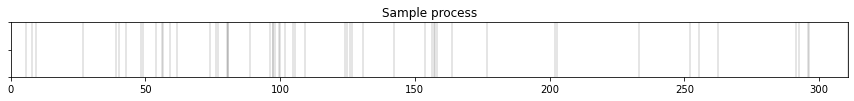

In [74]:
class exp_kernel:
    def __init__(self,params):
        self.α = params[0]
        self.β = params[1]
        
    def density(self,t,history):
        history_deltas = t.reshape(-1,1) - history
        timing_mask = history_deltas>0
        raw = self.α*np.exp(-self.β*(history_deltas*timing_mask))
        return np.sum(raw*timing_mask,1)
    
    def cumulative(self,T,history):
        return np.sum((self.α/self.β)*(1-np.exp(-self.β*(T-history))))
    
    def cumulative_intervals(self,grid,history):
        intervals = np.zeros(grid.reshape(-1,1).shape[0])
        intervals[0] = 0 
        for t in range(1,intervals.shape[0]):
            conditional_history = history[history<grid[t]]
            intervals[t] = np.sum((self.α/self.β)*(
                np.exp(-self.β*(grid[t-1]-conditional_history))-np.exp(-self.β*(grid[t]-conditional_history)))) 
        return intervals
    
class histogram_baseline:
    def __init__(self,T,params):
        self.mu = np.array(params)
        self.length = T/len(params)
        self.T = T
        
    def density(self,t):
        indices = [math.floor(step) for step in t/self.length]
        return  self.mu[indices].reshape(-1,1)
    
    def cumulative(self,T,t):
        indices = [math.floor(step) for step in t/self.length]
        cumulative = np.zeros(len(t))
        cumulative[0] = self.mu[indices[0]]*t[0]
        for i in range(1,len(cumulative)):
            if indices[i]==indices[i-1]:
                cumulative[i] = self.mu[indices[i]]*(t[i]-t[i-1])
            else:
                tau = indices[i]*self.length
                cumulative[i] = (self.mu[indices[i]  ]*(t[i]-tau) +
                                 self.mu[indices[i-1]]*(tau-t[i-1]))
        return cumulative.reshape(-1,1)
    
T = 360
dataframe = pd.read_csv(datapath + "Unidi_Sample.csv",index_col=0)
sample_process = dataframe.sample(1)
print("Actual parameters: ",sample_process["Params"][0])
timing_string = sample_process["Observations"][0].split(" ")[1:-1]
timing_string =[time.strip().strip('') for time in timing_string]
timeseries = np.array([float(k) for k in list(filter(None,timing_string))])
timeseries = timeseries[timeseries<T]
fig, ax = plt.subplots(nrows=1,figsize=(15, 1))
ax.set_yticklabels([])
ax.set_xlim(xmin=0,xmax=timeseries[-1])
for xc in zip(timeseries):
    ax.axvline(x=xc,c='black',linewidth=0.2)
ax.set_title('Sample process')
plt.show()

The EM loop itself is fairly simple.

### E-step

Given starting estimates of the baseline $\mu(t_j)$ and endogenous feedback $g(t_j)$, we can attribute whether each event was caused by baseline or endogenous intensity using the Poisson thinning theorem (and our conditionally independent intensity): 

$p_\mu = P(t_j$ is baseline$)   = \mu(t_j)/(\mu(t_j)+g(t_j))$

$p_g = P(t_j$ is endogenous$) = g(t_j)/(\mu(t_j)+g(t_j))$

### M-step

Conditional on $p_\mu$ and $p_g$, we can estimate parameters that maximizet the attributed likelihood function

$
ll(Y) = \sum_{j\geq1} p_\mu\left[log(\mu(t_j)) -\int_{t_0}^{T}\mu(\tau)d\tau\right] + p_g\left[log(g(t_j|H_j)) -\int_{t_0}^{T}g(\tau|H_\tau)d\tau\right]
$

Then iterate until the parameters converge. 

Below is a sample implementation:

In [76]:
class EM_hist:
    def  __init__(self,Y,bins):
        self.bins = bins
        self.params = list(np.ones(bins)*1e-2) + [1e-3,1e-2]
        self.T = 360
        self.Y = Y
        self.kernel = exp_kernel(self.params[-2:])
        self.baseline = histogram_baseline(self.T,self.params[:-2])

    def fit(self,max_iter=100):
        EM_hist.E(self)
        for k in tqdm(range(max_iter)):
            # E-step: reassign weights
            EM_hist.E(self)
            # M-step: perform MLE
            EM_hist.M(self)
        return self.params
    
    def E(self):
        h_0 = self.baseline.density(self.Y).reshape(-1,1)
        h_1 = self.kernel.density(self.Y,self.Y).reshape(-1,1)
        self.p_base = (h_0/(h_0+h_1))
        self.p_endog = (h_1/(h_0+h_1))  
        return
    
    def M(self):
        # given current weights, restimate params
        starting_params = self.params
        bnds=((1e-5,np.inf),)*self.bins + ((1e-5,np.inf),(1e-5,np.inf))
        optimizer = minimize(EM_hist.ll, [starting_params],args=(self),method='L-BFGS-B',bounds=bnds)
        self.params = optimizer.x
        return 
    
    def ll(params,self):
        safety = 1e-9 
        # update functions with new params
        self.kernel = exp_kernel(params[-2:])
        self.baseline = histogram_baseline(self.T,params[:-2])
        
        # likelihood of base events
        h_0 = self.baseline.density(self.Y)
        H_0 = self.baseline.cumulative(self.T,self.Y)
        ll = np.sum(np.multiply(self.p_base.reshape(1,-1), np.log(safety + h_0)-H_0))
        
        # likelihood of endogenous events
        h_1 = self.kernel.density(self.Y,self.Y)
        H_1 = self.kernel.cumulative_intervals(self.Y,self.Y)
        #H_1[0] = self.kernel.cumulative_intervals(0,self.Y[0],[])
        #for i in range(len(self.Y)):
        #    H_1[i] = self.kernel.cumulative_intervals(self.Y[i-1],self.Y[i],self.Y[:i])
        ll += np.sum(np.multiply(self.p_endog, (np.log(safety + h_1)-H_1).reshape(-1,1)))
        
        return -ll

EM_estimator = EM_hist(timeseries,20)
params = EM_estimator.fit(100)
print("Estimated kernel parameters: ", params[-2:])
print("Actual parameters:           ", sample_process["Params"][0])

  0%|          | 0/100 [00:00<?, ?it/s]

Estimated kernel parameters:  [0.04169827 0.04272763]
Actual parameters:            [0.077762955968873, 0.5079828359342705]


The kernel parameters are much closer to correct, but still not correct. In our case, this is mostly caused by not having enough data per bin. If we plot the estimated baselines we'll see that in crucial periods with many datapoints we are close to correct, but low latency-peridods lead to near-zero estimates. 

There is a clear tradeoff at play: to get the correct shape of the baseline, we need more batches, but to get more robust estimates we need fewer batches. In either case, we do not have the correct baseline to recover the kernel parameters either. To escape this situation, we'll need to relax the assumption of bin independence and that will require considerably more sophisticated mathematics.

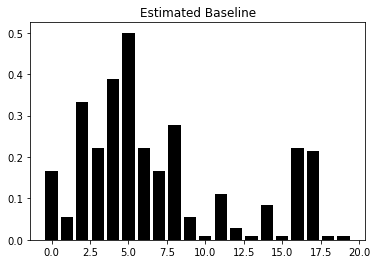

In [79]:
# EM_estimator.p_base
plt.title("Estimated Baseline")
plt.bar(range(len(params[:-2])),params[:-2],color="black")
plt.show()

Nonetheless, if we estimate the mean inferred intensity (weighting each half by attribution probability) and the mean cumulative intensity, we'll see that we are much closer to correct than before.

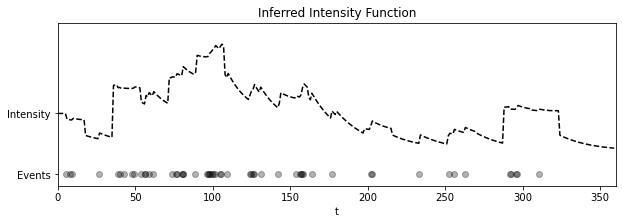

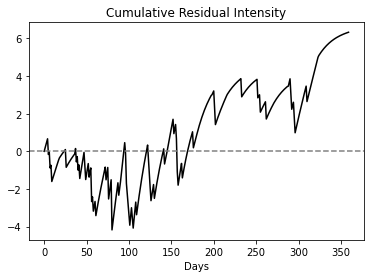

In [80]:
timesteps = np.linspace(0, T-1, T)
h0 = histogram_baseline(T,params[:-2]).density(timesteps).reshape(-1,)
h1 = exp_kernel(params[-2:]).density(timesteps,timeseries)
p0 = h0/(h0+h1) 
p1 = h1/(h0+h1)
pred_intensity = h0*p0 + h1*p1

fig, ax = plt.subplots(nrows=1,figsize=(10, 3))
ax.set_xlim(xmin=0,xmax=T)
ax.set_ylim(ymin=-0.15,ymax=1.2*(max(pred_intensity)))
ax.scatter(timeseries,np.zeros(len(timeseries))-0.1, color = "black", alpha=0.3)
ax.plot(timesteps,pred_intensity,color="black",linestyle='--')
ax.set_xlabel("t")
ax.set_yticks([-0.1,pred_intensity[0]])
ax.set_yticklabels(["Events","Intensity"])
ax.set_title("Inferred Intensity Function")
plt.show()

H0 = histogram_baseline(T,params[:-2]).cumulative(T,timesteps).reshape(-1,)
H1 = exp_kernel(params[-2:]).cumulative_intervals(timesteps,timeseries)
cum_pred = H0*p0 + H1*p1 

event_counts = np.zeros(T)
for t in range(T):
    event_counts[t] += np.sum((t<timeseries)&(timeseries<(t+1)))
plt.plot(np.cumsum(cum_pred - event_counts),color='black')
plt.axhline(0,linestyle='--',color='grey')
plt.title("Cumulative Residual Intensity")
plt.xlabel("Days")
plt.show()

# Bibliography

Lewis, E., & Mohler, G. (2011). A Nonparametric EM algorithm for Multiscale Hawkes Processes. Journal of Nonparametric Statistics, 1(1), 1–20.